In [11]:
# Do the necessary imports
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, transpile
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit.extensions import Initialize
from qiskit.result import marginal_counts
from qiskit.quantum_info import random_statevector
# Importing everything
from qiskit import QuantumCircuit
from qiskit import IBMQ, Aer, transpile
from qiskit.visualization import plot_histogram
from numpy.random import randint

## Teleportation

In [17]:
# CREATING THE TELEPORTATION CIRCUIT

def create_bell_pair(qc, a, b):
    """Creates a bell pair in qc using qubits a & b"""
    qc.h(a) # Put qubit a into state |+>
    qc.cx(a,b) # CNOT with a as control and b as target

def alice_gates(qc, psi, a):
    qc.cx(psi, a)
    qc.h(psi)

def measure_and_send(qc, a, b):
    """Measures qubits a & b and 'sends' the results to Bob"""
    qc.barrier()
    qc.measure(a,0)
    qc.measure(b,1)

def bob_gates(qc, qubit, crz, crx):
    # Here we use c_if to control our gates with a classical
    # bit instead of a qubit
    qc.x(qubit).c_if(crx, 1) # Apply gates if the registers 
    qc.z(qubit).c_if(crz, 1) # are in the state '1'

## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
create_bell_pair(teleportation_circuit, 1, 2)

## STEP 2
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)

## STEP 3
measure_and_send(teleportation_circuit, 0, 1)

## STEP 4
teleportation_circuit.barrier() # Use barrier to separate steps
bob_gates(teleportation_circuit, 2, crz, crx)
teleportation_circuit.draw()

░      ┌───┐ ░ ┌─┐    ░               
  q_0: ───────────░───■──┤ H ├─░─┤M├────░───────────────
       ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐ ░               
  q_1: ┤ H ├──■───░─┤ X ├──────░──╫─┤M├─░───────────────
       └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘ ░  ┌───┐  ┌───┐ 
  q_2: ─────┤ X ├─░────────────░──╫──╫──░──┤ X ├──┤ Z ├─
            └───┘ ░            ░  ║  ║  ░  └─╥─┘  └─╥─┘ 
                                  ║  ║       ║   ┌──╨──┐
crz: 1/═══════════════════════════╩══╬═══════╬═══╡ 0x1 ╞
                                  0  ║    ┌──╨──┐└─────┘
crx: 1/══════════════════════════════╩════╡ 0x1 ╞═══════
                                     0    └─────┘

### Testing the teleportation protocol

<IPython.core.display.Latex object>

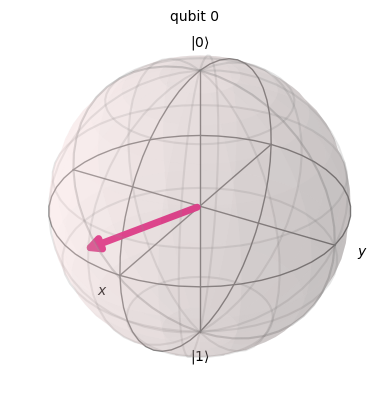

In [3]:
# Create random 1-qubit state
psi = random_statevector(2)

# Display it nicely
display(array_to_latex(psi, prefix="|\\psi\\rangle ="))
# Show it on a Bloch sphere
plot_bloch_multivector(psi)

In [5]:
init_gate = Initialize(psi)
init_gate.label = "init"

## SETUP
qr = QuantumRegister(3, name="q")   # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical registers
crx = ClassicalRegister(1, name="crx")
qc = QuantumCircuit(qr, crz, crx)

## STEP 0
# First, let's initialize Alice's q0
qc.append(init_gate, [0])
qc.barrier()

## STEP 1
# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()

## STEP 2
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)

## STEP 3
# Alice then sends her classical bits to Bob
measure_and_send(qc, 0, 1)

## STEP 4
# Bob decodes qubits
bob_gates(qc, 2, crz, crx)

# Display the circuit
qc.draw(fold = 200)

┌──────────────────────────────────────────┐ ░            ░      ┌───┐ ░ ┌─┐                 
  q_0: ┤ init(0.31663-0.38132j,-0.53273-0.68596j) ├─░────────────░───■──┤ H ├─░─┤M├─────────────────
       └──────────────────────────────────────────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐              
  q_1: ─────────────────────────────────────────────░─┤ H ├──■───░─┤ X ├──────░──╫─┤M├──────────────
                                                    ░ └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘ ┌───┐  ┌───┐ 
  q_2: ─────────────────────────────────────────────░──────┤ X ├─░────────────░──╫──╫──┤ X ├──┤ Z ├─
                                                    ░      └───┘ ░            ░  ║  ║  └─╥─┘  └─╥─┘ 
                                                                                 ║  ║    ║   ┌──╨──┐
crz: 1/══════════════════════════════════════════════════════════════════════════╩══╬════╬═══╡ 0x1 ╞
                                                                                 0  ║ ┌──╨──┐└─────┘
crx: 1/═════════════════════════════════════════════════════════════════════════════╩═╡ 0x1 ╞═══════
                                                                                    0 └─────┘

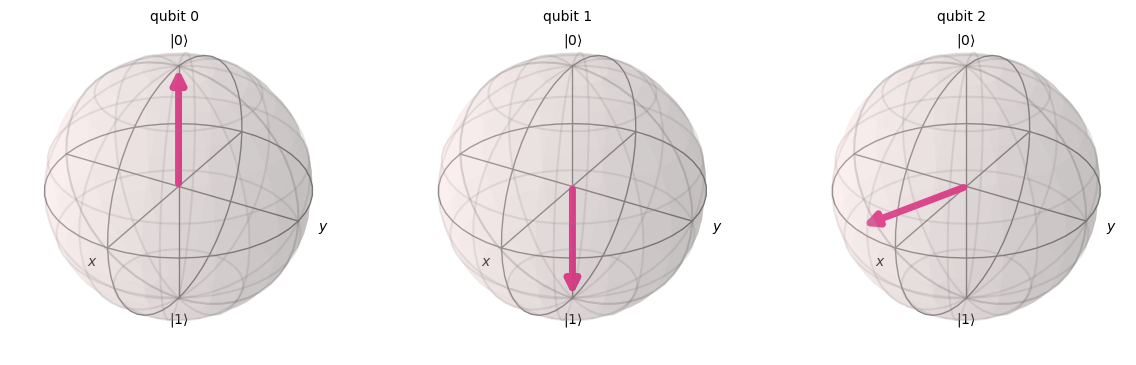

In [6]:
sim = Aer.get_backend('aer_simulator')
qc.save_statevector()
out_vector = sim.run(qc).result().get_statevector()
plot_bloch_multivector(out_vector)

## Super-dense coding

### Step 1 <a id='step1'></a>
The process starts with a third party, who we'll call Charlie. Two qubits are prepared by Charlie in an entangled state. He initially starts the 2 qubits in the basis state $|0\rangle$. He applies Hadamard gate ($H$) to the first qubit to create superposition. He then applies CNOT gate ($CX$) using the first qubit as a control and the second as the target. This is the entangled state (Bell pair) we mentioned earlier. 

#### Outcome States

We start in the state:

$$|00\rangle = |0\rangle_A\otimes |0\rangle_B$$

where the qubit to be sent to Alice is labeled with $A$ and the qubit to be sent to Bob is labeled $B$. Charlie first applies a Hadamard gate to the first qubit, which creates superposition and we get the state:


$$|+0\rangle  =  \tfrac{1}{\sqrt{2}}(|00\rangle + |10\rangle)$$



Then Charlie applies the CNOT gate. The CNOT gate entangles both qubits, i.e. it flips the target if the control is $|1\rangle$. Note that the control qubit is our leftmost qubit.



$$\text{CNOT} \tfrac{1}{\sqrt{2}}(|00\rangle + |10\rangle) = \tfrac{1}{\sqrt{2}}(|00\rangle + |11\rangle)$$



### Step 2 <a id='step2'></a>

Charlie sends the first qubit to Alice and the second qubit to Bob. The goal of the protocol is for Alice to send 2 classical bits of information to Bob using her qubit. But before she does, she needs to apply a set of quantum gates to her qubit depending on the 2 bits of information she wants to send:


#### Encoding Rules for Superdense Coding (Alice protocol):
<table>
    <tr>
        <th>Intended Message</th>
        <th>Applied Gate</th>
        <th>Resulting State (1/sqrt(2))</th>
    </tr>
    <tr>
        <td>00</td>
        <td>I</td>
        <td>|00\ + |11\ </td>
    </tr>
    <tr>
        <td>01</td>
        <td>X</td>
        <td>|10\ + |01\ </td>
    </tr>
    <tr>
        <td>10</td>
        <td>Z</td>
        <td>|00\ - |11\</td>
    </tr>
    <tr>
        <td>11</td>
        <td>ZX</td>
        <td>-|10\ + |01\</td>
    </tr>
</table>

Thus if she wants to send a `00`, she does nothing to her qubit (apply the identity ($I$) gate). If she wants to send a `01`, then she applies the $X$ gate. Depending on what she wants to send, she applies the appropriate gate, then sends her qubit to Bob for the final step in the process.


### Step 3 <a id='step3'></a>

Bob receives Alice's qubit (leftmost qubit) and uses his qubit to decode Alice's message. Notice that he does not need to have knowledge of the state in order to decode it — he simply uses the restoration operation.

Bob applies a CNOT gate using the leftmost qubit as control and the rightmost as target. Then he applies a Hadamard gate and finally performs a measurement on both qubits to extract Alice's message.

<table>
    <tr>
        <th>Bob Receives </th>
        <th>After CNOT-gate </th>
        <th>After H-gate</th>
    </tr>
    <tr>
        <td>|00\ + |11\</td>
        <td>|00\ + |10\</td>
        <td>|00\</td>
    </tr>
    <tr>
        <td>|10\ + |01\</td>
        <td>|11\ + |01\</td>
        <td>|01\</td>
    </tr>
    <tr>
        <td>|00\ - |11\</td>
        <td>|00\ - |10\</td>
        <td>|10\</td>
    </tr>
    <tr>
        <td>-|10\ + |01\</td>
        <td>-|11\ + |01\</td>
        <td>|11\</td>
    </tr>
</table>

### Simulating the Superdense Coding Protocol <a id='simulating'></a>

In [9]:
def create_bell_pair():
    """
    Returns:
        QuantumCircuit: Circuit that produces a Bell pair
    """
    qc = QuantumCircuit(2)
    qc.h(1)
    qc.cx(1, 0)
    return qc

def encode_message(qc, qubit, msg):
    """Encodes a two-bit message on qc using the superdense coding protocol
    Args:
        qc (QuantumCircuit): Circuit to encode message on
        qubit (int): Which qubit to add the gate to
        msg (str): Two-bit message to send
    Returns:
        QuantumCircuit: Circuit that, when decoded, will produce msg
    Raises:
        ValueError if msg is wrong length or contains invalid characters
    """
    if len(msg) != 2 or not set(msg).issubset({"0","1"}):
        raise ValueError(f"message '{msg}' is invalid")
    if msg[1] == "1":
        qc.x(qubit)
    if msg[0] == "1":
        qc.z(qubit)
    return qc

def decode_message(qc):
    qc.cx(1, 0)
    qc.h(1)
    return qc

# Charlie creates the entangled pair between Alice and Bob
qc = create_bell_pair()

# We'll add a barrier for visual separation
qc.barrier()

# At this point, qubit 0 goes to Alice and qubit 1 goes to Bob

# Next, Alice encodes her message onto qubit 1. In this case,
# we want to send the message '10'.
message = '10'
qc = encode_message(qc, 1, message)
qc.barrier()
# Alice then sends her qubit to Bob.

# After receiving qubit 0, Bob applies the recovery protocol:
qc = decode_message(qc)

# Finally, Bob measures his qubits to read Alice's message
qc.measure_all()

# Draw our output
qc.draw()

┌───┐ ░       ░ ┌───┐      ░ ┌─┐   
   q_0: ─────┤ X ├─░───────░─┤ X ├──────░─┤M├───
        ┌───┐└─┬─┘ ░ ┌───┐ ░ └─┬─┘┌───┐ ░ └╥┘┌─┐
   q_1: ┤ H ├──■───░─┤ Z ├─░───■──┤ H ├─░──╫─┤M├
        └───┘      ░ └───┘ ░      └───┘ ░  ║ └╥┘
meas: 2/═══════════════════════════════════╩══╩═
                                           0  1

{'10': 1024}


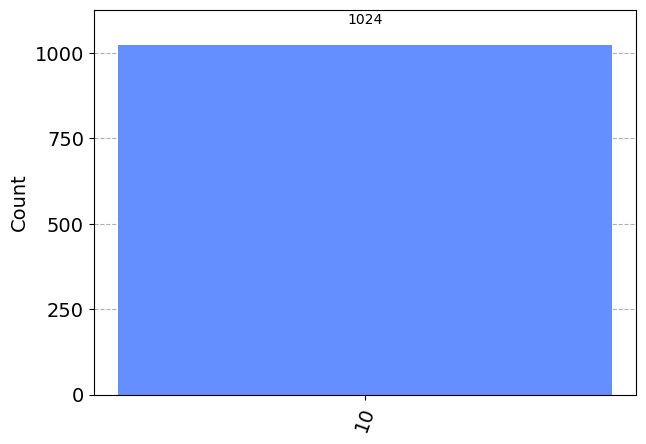

In [10]:
aer_sim = Aer.get_backend('aer_simulator')
result = aer_sim.run(qc).result()
counts = result.get_counts(qc)
print(counts)
plot_histogram(counts)

## BB84 QKD

The key distribution protocol is roughly as follows:

**- Step 1**

Alice chooses a string of random bits, e.g.:

`1000101011010100`

And a random choice of basis for each bit:

`ZZXZXXXZXZXXXXXX`

Alice keeps these two pieces of information private to herself. 

**- Step 2**

Alice then encodes each bit onto a string of qubits using the basis she chose; this means each qubit is in one of the states $|0\rangle$, $|1\rangle$, $|+\rangle$ or $|-\rangle$, chosen at random. In this case, the string of qubits would look like this:

$$ |1\rangle|0\rangle|+\rangle|0\rangle|-\rangle|+\rangle|-\rangle|0\rangle|-\rangle|1\rangle|+\rangle|-\rangle|+\rangle|-\rangle|+\rangle|+\rangle
$$

This is the message she sends to Bob.

**- Step 3**

Bob then measures each qubit at random, for example, he might use the bases:

`XZZZXZXZXZXZZZXZ`

And Bob keeps the measurement results private.

**- Step 4**

Bob and Alice then publicly share which basis they used for each qubit. If Bob measured a qubit in the same basis Alice prepared it in, they use this to form part of their shared secret key, otherwise they discard the information for that bit.

**- Step 5**

Finally, Bob and Alice share a random sample of their keys, and if the samples match, they can be sure (to a small margin of error) that their transmission is successful.

In [13]:
n = 100

# HELPER FUNCTIONS FOR LATER USAGE
def encode_message(bits, bases):
    message = []
    for i in range(n):
        qc = QuantumCircuit(1,1)
        if bases[i] == 0: # Prepare qubit in Z-basis
            if bits[i] == 0:
                pass 
            else:
                qc.x(0)
        else: # Prepare qubit in X-basis
            if bits[i] == 0:
                qc.h(0)
            else:
                qc.x(0)
                qc.h(0)
        qc.barrier()
        message.append(qc)
    return message

def measure_message(message, bases):
    backend = Aer.get_backend('aer_simulator')
    measurements = []
    for q in range(n):
        if bases[q] == 0: # measuring in Z-basis
            message[q].measure(0,0)
        if bases[q] == 1: # measuring in X-basis
            message[q].h(0)
            message[q].measure(0,0)
        aer_sim = Aer.get_backend('aer_simulator')
        result = aer_sim.run(message[q], shots=1, memory=True).result()
        measured_bit = int(result.get_memory()[0])
        measurements.append(measured_bit)
    return measurements

def remove_garbage(a_bases, b_bases, bits):
    good_bits = []
    for q in range(n):
        if a_bases[q] == b_bases[q]:
            # If both used the same basis, add
            # this to the list of 'good' bits
            good_bits.append(bits[q])
    return good_bits

### a) Without interception

In [15]:
np.random.seed(seed=0)
n = 100

## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)

## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)

## Step 3
# Decide which basis to measure in:
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)

## Step 4
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
print("Do Alice and Bob's keys match? - ", (bob_key == alice_key))

Do Alice and Bob's keys match? -  True


### a) With Eve interception

In [16]:
np.random.seed(seed=3)
## Step 1
alice_bits = randint(2, size=n)
## Step 2
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)
## Interception!!
eve_bases = randint(2, size=n)
intercepted_message = measure_message(message, eve_bases)
## Step 3
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)
## Step 4
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)

print("Do Alice and Bob's keys match? - ", (bob_key == alice_key))

Do Alice and Bob's keys match? -  False
